This notebook trains the GMM and saves the model to a pickle file in `../models/gmm.pkl`. To train the GMM, we first use PCA to reduce the dimension of the input space. The PCA model is also saved in `../models/pca_gmm.pkl`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm

sns.set_theme(style = 'dark')

# Assemble Dataset

In [2]:
DATA_DIR = '../../data/combined_macro_micro_wind_data.csv'

data = pd.read_csv(DATA_DIR)

# isolate U and V columns
u_cols = [f'u{i}' for i in np.arange(20, 255, 5)]
v_cols = [f'v{i}' for i in np.arange(20, 255, 5)]
macro_cols = ['macro_ws', 'macro_wd']

# big dataset
data_full = data[u_cols + v_cols + macro_cols]

# remove the empty columns and rows
data_full.dropna(inplace=True)
print(data_full.shape)

data_u = data_full[u_cols].copy()
data_v = data_full[v_cols].copy()

# average over altitude for visualization
data_uv = np.zeros(shape=(data_u.shape[0], 2))
data_uv[:, 0] = data_u.values.mean(axis=1)
data_uv[:, 1] = data_v.values.mean(axis=1)

# define the indices for the u and v components
u_idxs = np.arange(47)
v_idxs = np.arange(47, 94)

# include macro data
macro_cols = [col for col in data_full.columns.values if 'macro' in col]
macro_cols_w = ['macro_ws', 'macro_wd']

data_macro = data_full[macro_cols].copy()

(6542, 96)


C:\Users\mcstanl1\AppData\Local\Temp\1\ipykernel_23860\1227225927.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_full.dropna(inplace=True)


In [3]:
def wd_s_to_uv(ws, wd):
    """
    Translate wind speed and direction to (u,v).
    """
    return -ws * np.sin(wd * (np.pi / 180.)), -ws * np.cos(wd * (np.pi / 180.))

def wd_s_to_u(ws, wd):
    """
    Translate wind speed and direction to u.
    """
    return -ws * np.sin(wd * (np.pi / 180.))

def wd_s_to_v(ws, wd):
    """
    Translate wind speed and direction to v.
    """
    return -ws * np.cos(wd * (np.pi / 180.))

In [4]:
# create dataframe for macro
data_wind_macro = data_full[u_cols + v_cols].copy()

# create columns for macro u and v
data_wind_macro['u_macro'] = data_full.apply(lambda x: wd_s_to_u(ws=x['macro_ws'], wd=x['macro_wd']), axis=1)
data_wind_macro['v_macro'] = data_full.apply(lambda x: wd_s_to_v(ws=x['macro_ws'], wd=x['macro_wd']), axis=1)
print(data_wind_macro.shape)

(6542, 96)


# Fit PCA and GMM models

In [5]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

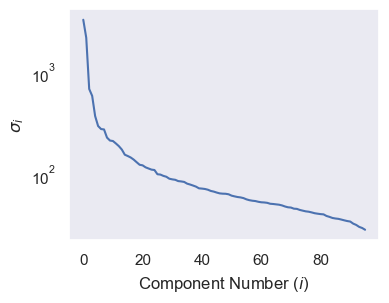

In [6]:
# compute principal components
pca = PCA()
pca.fit(data_wind_macro)

plt.figure(figsize=(4, 3))
plt.plot(pca.singular_values_)
plt.yscale('log')
plt.xlabel('Component Number ($i$)')
plt.ylabel(r'$\sigma_i$')
plt.show()

0.9549815519675519 7


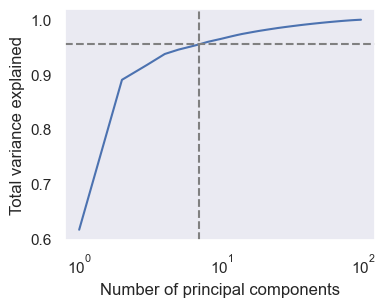

In [7]:
cumulative_var = pca.explained_variance_ratio_.cumsum()
num_pc_idx = np.where(cumulative_var > 0.959)[0][0]  # 0.9659702907131442
print(cumulative_var[num_pc_idx - 1], num_pc_idx)

plt.figure(figsize=(4, 3))
plt.plot(np.arange(1, len(pca.singular_values_) + 1), cumulative_var)
plt.xscale('log')
plt.axvline(num_pc_idx, linestyle='--', color='gray')
plt.axhline(cumulative_var[num_pc_idx - 1], linestyle='--', color='gray')
plt.ylabel('Total variance explained')
plt.xlabel('Number of principal components')
plt.show()

In [9]:
# set a number of PCs to use
NUM_PCS = num_pc_idx

# save orthogongal transformation -- "h" stands for "high-dimensional"
orth_pca_vecs = pca.components_[:NUM_PCS]

# apply transformation to data
data_pca = (data_wind_macro.values - data_wind_macro.values.mean(axis=0)) @ orth_pca_vecs.T
print(data_pca.shape)

# fit GMM on lower dimensional object
MAX_COMPONENTS = 27
gm_fits = []

# fit GMMs with 2 to MAX_COMPONENTS components
for K in tqdm(range(2, MAX_COMPONENTS + 1)):
    gm = GaussianMixture(
        n_components=K,
        covariance_type='full',
        max_iter=200,
        n_init=15
    ).fit(data_pca)
    gm_fits.append(gm)

(6542, 7)


  0%|          | 0/26 [00:00<?, ?it/s]

In [10]:
# save the data generated by pca
with open('../../data/pca_dim_reduced_data.npy', 'wb') as f:
    np.save(file=f, arr=data_pca)

#### LR and BIC test statistics to choose the number of components

In [ ]:
# compute the LLR test statistics
log_liks = np.array([gm_K.score_samples(data_pca).sum() for gm_K in gm_fits])
llrs = log_liks[1:] - log_liks[:-1]
llrs *= 2

# compute BIC for each model
bics = np.array([gm_K.bic(data_pca) for gm_K in gm_fits])

fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(10, 5))
ax[0].plot(np.arange(3, MAX_COMPONENTS + 1), llrs)
ax[0].set_xlabel('Number of Components ($K$)')
ax[0].set_ylabel('LLR')
ax[1].plot(np.arange(2, MAX_COMPONENTS + 1), bics)
ax[1].axvline(16, linestyle='--', color='gray')
ax[1].set_xlabel('Number of Components ($K$)')
ax[1].set_ylabel('BIC')
plt.tight_layout()
plt.show()

In [ ]:
# set the chosen model index -- looks like 22 components does a good job by BIC criterion
MODEL_IDX = 14

In [ ]:
# plots for paper
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(4, 8))

plot_data_arr = np.vstack((np.arange(1, len(pca.singular_values_) + 1), cumulative_var)).T
plot_data_arr_df = pd.DataFrame(plot_data_arr, columns=['num_pcs', 'tot_var_exp'])
plot_data_arr_bic = np.vstack((np.arange(2, MAX_COMPONENTS + 1), bics)).T
plot_data_arr_bic_df = pd.DataFrame(plot_data_arr_bic, columns=['num_comp', 'bic'])

# PCA diagnostic
# ax[0].plot(np.arange(1, len(pca.singular_values_) + 1), cumulative_var)
sns.lineplot(data=plot_data_arr_df, x='num_pcs', y='tot_var_exp', ax=ax[0])
ax[0].set_xscale('log')
ax[0].axvline(num_pc_idx, linestyle='--', color='gray')
ax[0].axhline(cumulative_var[num_pc_idx - 1], linestyle='--', color='gray')
ax[0].set_ylabel('Total variance explained')
ax[0].set_xlabel('Number of principal components ($C$)')

# BIC diagnostic
sns.lineplot(data=plot_data_arr_bic_df, x='num_comp', y='bic', ax=ax[1])
ax[1].set_xlabel('Number of Components ($K$)')
ax[1].axvline(MODEL_IDX + 2, linestyle='--', color='gray')
ax[1].set_ylabel('BIC')

plt.tight_layout()
plt.show()

### Save GMM and PCA models

In [ ]:
# GMM
with open('../../models/gmm.pkl','wb') as f:
    pickle.dump(gm_fits[MODEL_IDX], f)

# PCA
with open('../../models/pca.pkl','wb') as f:
    pickle.dump(pca, f)